In [1]:
import sys
import os
import json
import random 

import numpy as np                                                                  
import pandas as pd
import matplotlib.pyplot as plt                                                       

import cv2                                                                         
import mediapipe as mp  

from glob import glob                                                               
from pathlib import Path                                                            
from natsort import natsorted                                                       
from tqdm.auto import tqdm 

from sklearn.model_selection import train_test_split                                                
from collections import defaultdict
from typing import Callable, List, Tuple
from numpy.typing import NDArray

import torch
from torch import nn
import torch.optim as optim                                                          
import torch.nn.functional as F 
import seaborn as sns
from torch.utils.data import Dataset
from torch.utils.data import DataLoader 
    
from sklearn.metrics import confusion_matrix

In [2]:
sys.path.append(os.path.abspath('../src'))
import prepare_datasets
import preprocessing 
import models  
import training  

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  #set up device to cuda
print(device)

root_dir= os.path.dirname(os.getcwd())
data_dir= os.path.join(root_dir, 'data')
lsa= os.path.join(data_dir, 'landmarks_lsa64')

print(f'LSA64 landmark directory: {lsa}')

# loading detections and labels for lsa 64 dataset
lsa64_labels = {'30fps': None, '40fps': None, '50fps': None, '60fps': None}
lsa64 = {'30fps': None, '40fps': None, '50fps': None, '60fps': None}
for i in [30, 40, 50, 60]:
    lsa64[f'{i}fps']= np.load(os.path.join(lsa, f'detections{i}fps.npy'), allow_pickle=True)
    with open(os.path.join(lsa, f'labels{i}fps.json'), 'r') as file:
        lsa64_labels[f'{i}fps']= json.load(file)

cuda
LSA64 landmark directory: C:\Users\sadeg\OneDrive\Desktop\Thesis\python_codes\SignLanguageProject\data\landmarks_lsa64


In [4]:
lsa64['30fps'].shape, lsa64['40fps'].shape, lsa64['50fps'].shape, lsa64['60fps'].shape

((3200, 30, 1662), (3200, 40, 1662), (3200, 50, 1662), (3200, 60, 1662))

In [47]:
video1= lsa64['60fps'][0]
video2= lsa64['60fps'][48]
ivd= preprocessing.interpolate_video_detections(video1, video2, [(0, 132), (132, 1536), (1536, 1599), (1599, 1662)], 0.5)
video1.shape, video2.shape, ivd.shape

((60, 1662), (60, 1662), (60, 1662))

In [50]:
preprocessing.show_detections(ivd)

In [5]:
def set_train_parameters(detections: NDArray[np.float64], 
                         labels: List[str],
                         class_names: List[str],
                         test_size: float,
                         random_state: int,
                         batch_size: int,
                         num_epochs: int,
                         model: torch.nn.Module,
                         learning_rate: float,
                         device: torch.device):
    
    
    xtrain, xtest, ytrain, ytest= preprocessing.split_dataset(detections, labels, class_names, test_size, random_state)
    train_dataset= preprocessing.CustomDataset(xtrain, ytrain)
    test_dataset= preprocessing.CustomDataset(xtest, ytest)
    train_dataloader = DataLoader(dataset=train_dataset, batch_size= batch_size, num_workers=0, shuffle=True) 
    test_dataloader = DataLoader(dataset=test_dataset, batch_size= batch_size, num_workers=0, shuffle=False) 
    
    model= model.to(device)                  
    
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr= learning_rate)
    
    train_losses, test_losses, train_accuracies, test_accuracies, y_trues, y_preds = training.train(num_epochs, model, train_dataloader, test_dataloader, optimizer, loss_fn, training.accuracy_fn, device)
    training.plot_loss_accuracy(train_losses, test_losses, train_accuracies, test_accuracies, batch_size)
    training.plot_confusion_matrix(y_trues, y_preds, class_names, num_epochs)

Training Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

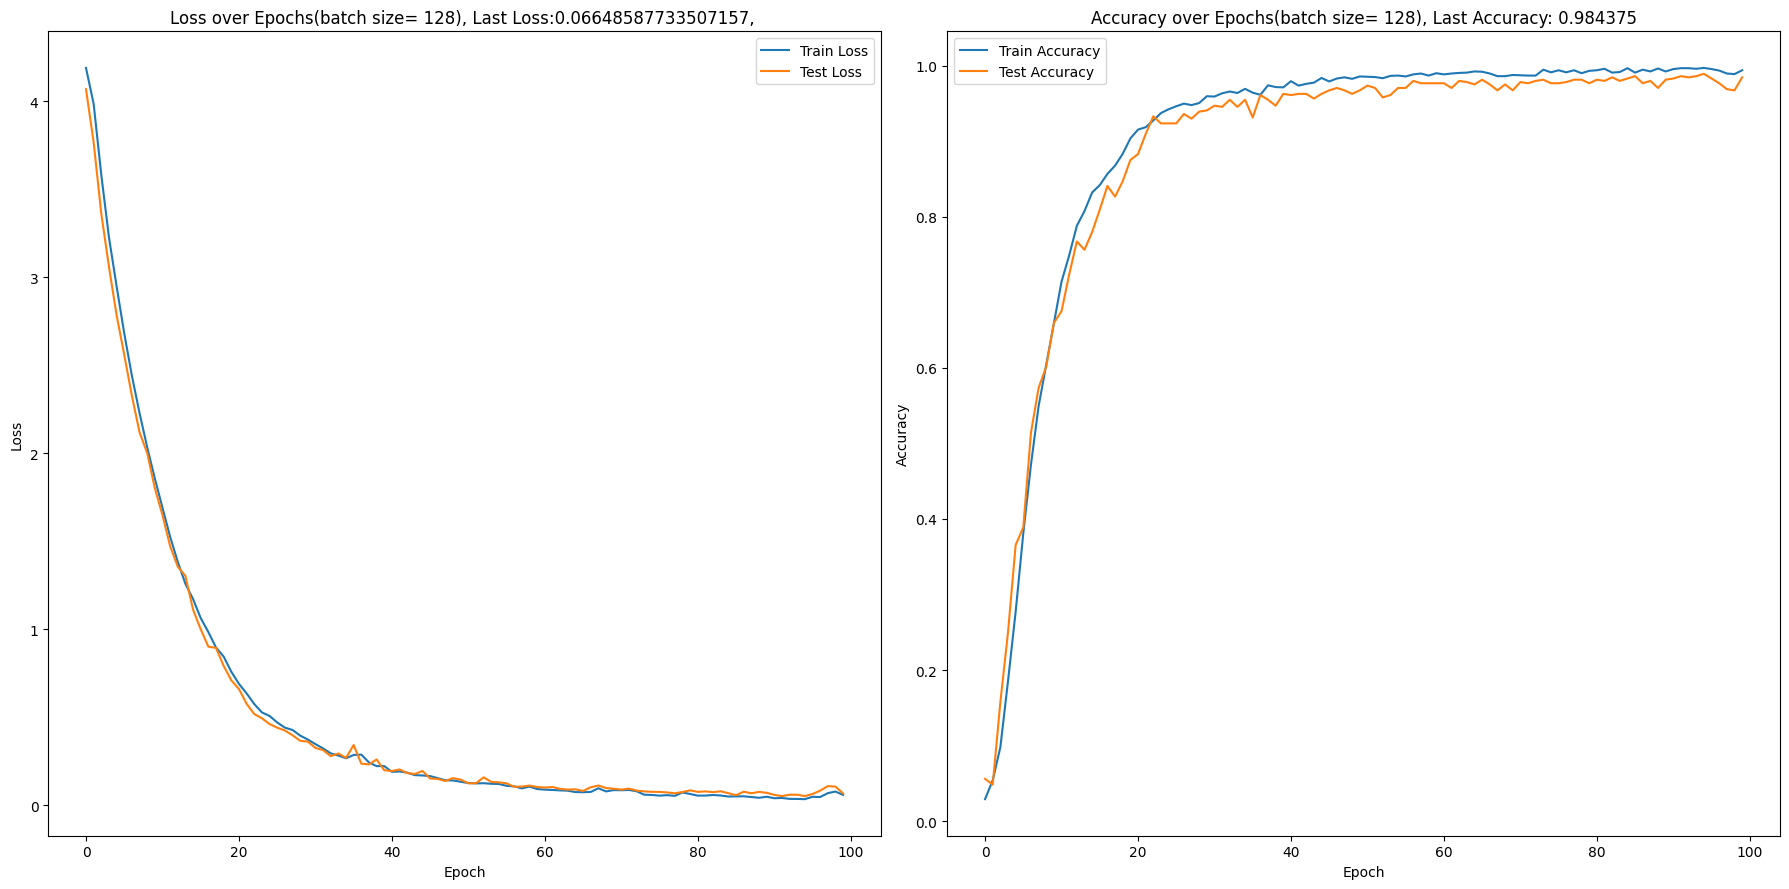

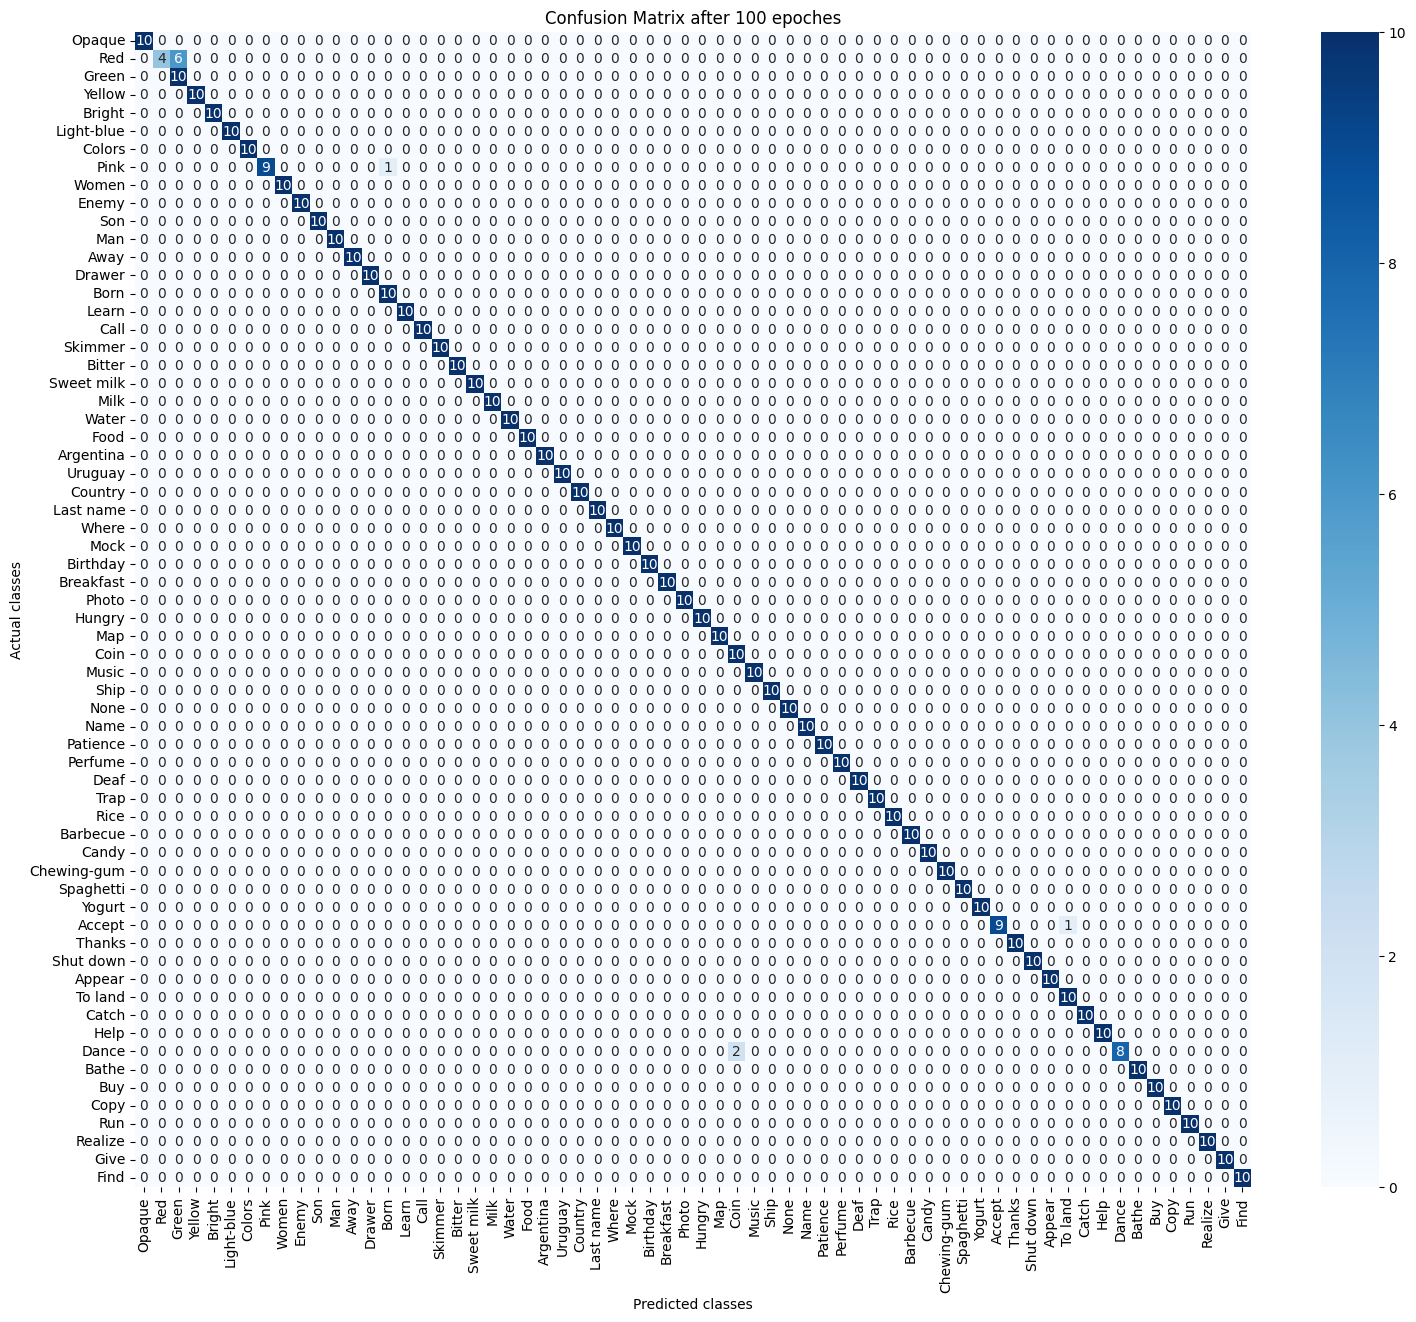

In [6]:
model= models.ConvoTransformer(prepare_datasets.lsa64class_names, 40, 128, 4, 2048, 2, 1662, 1)
set_train_parameters(lsa64['40fps'], lsa64_labels['40fps'], prepare_datasets.lsa64class_names, 0.2, 42, 128, 100, model, 0.0001, device)

Training Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

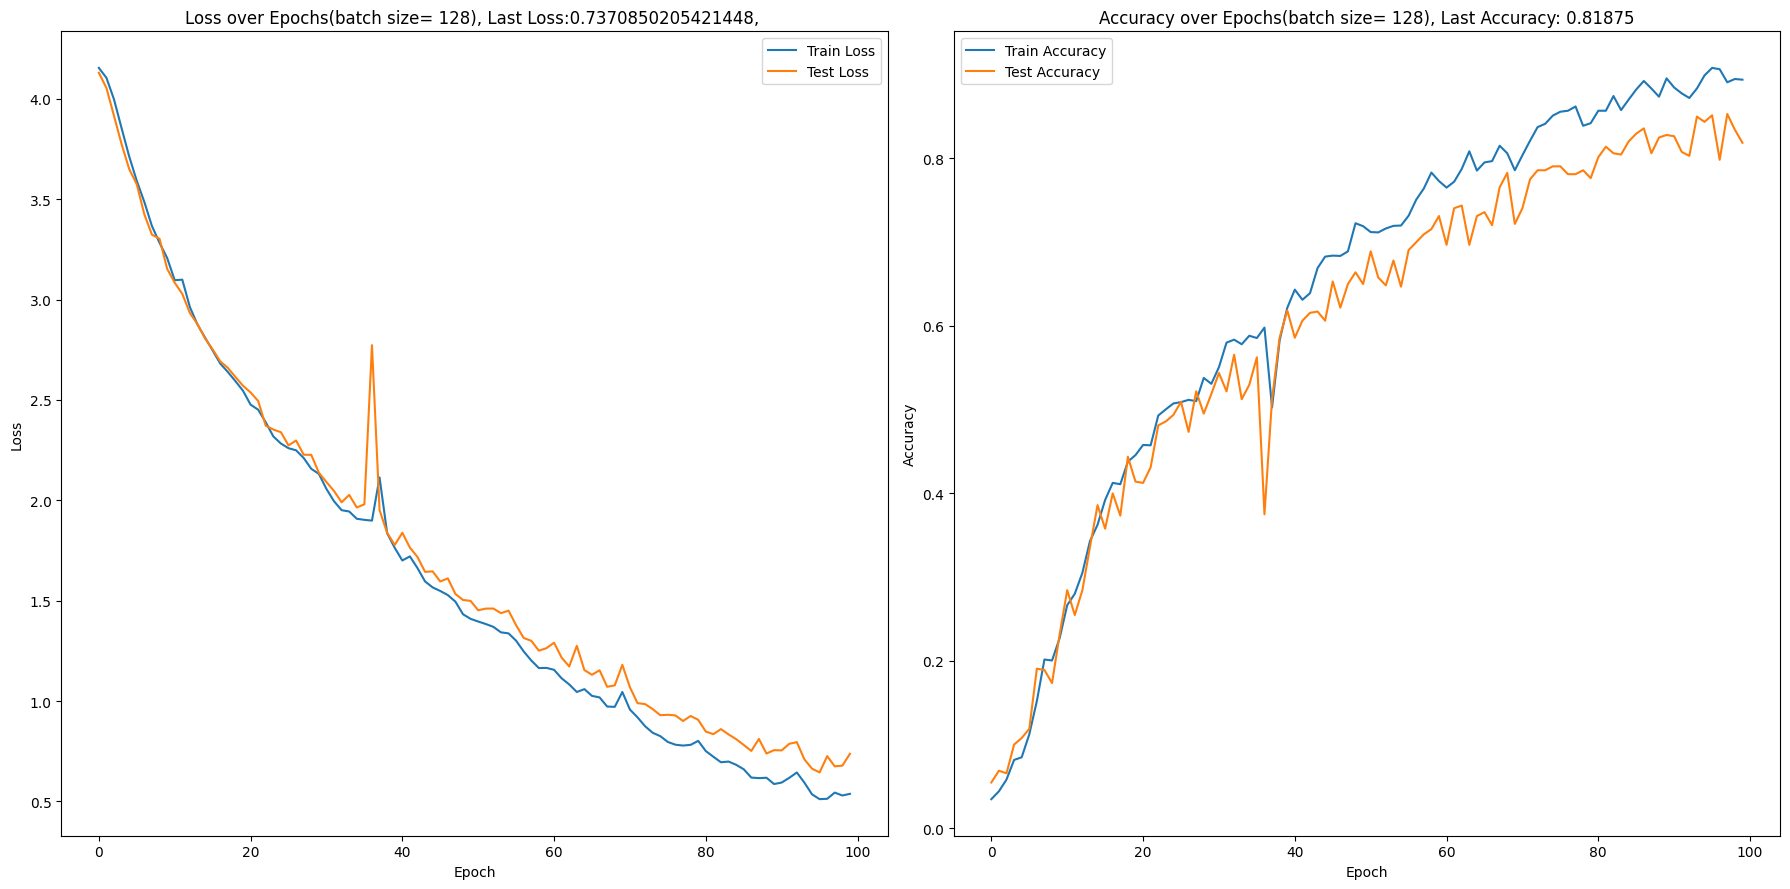

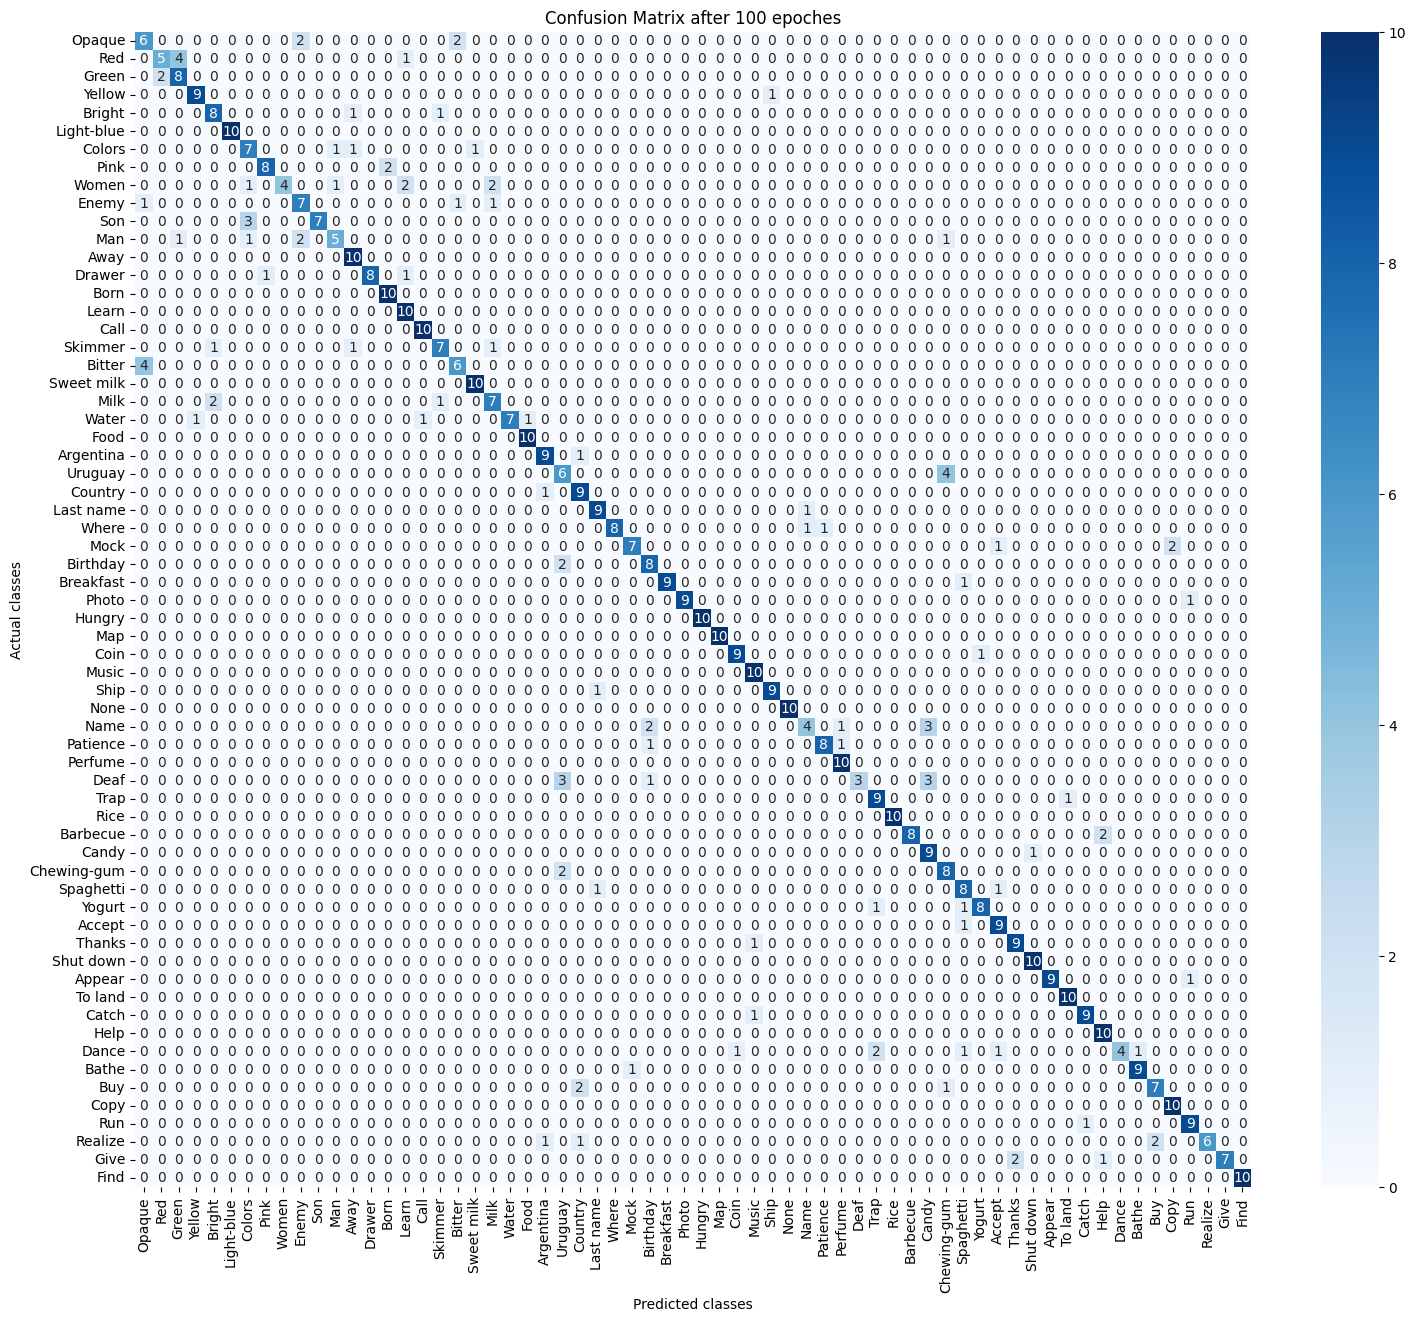

In [7]:
model= models.LstmModel(prepare_datasets.lsa64class_names)
set_train_parameters(lsa64['40fps'], lsa64_labels['40fps'], prepare_datasets.lsa64class_names, 0.2, 42, 128, 100, model, 0.0001, device)

Training Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

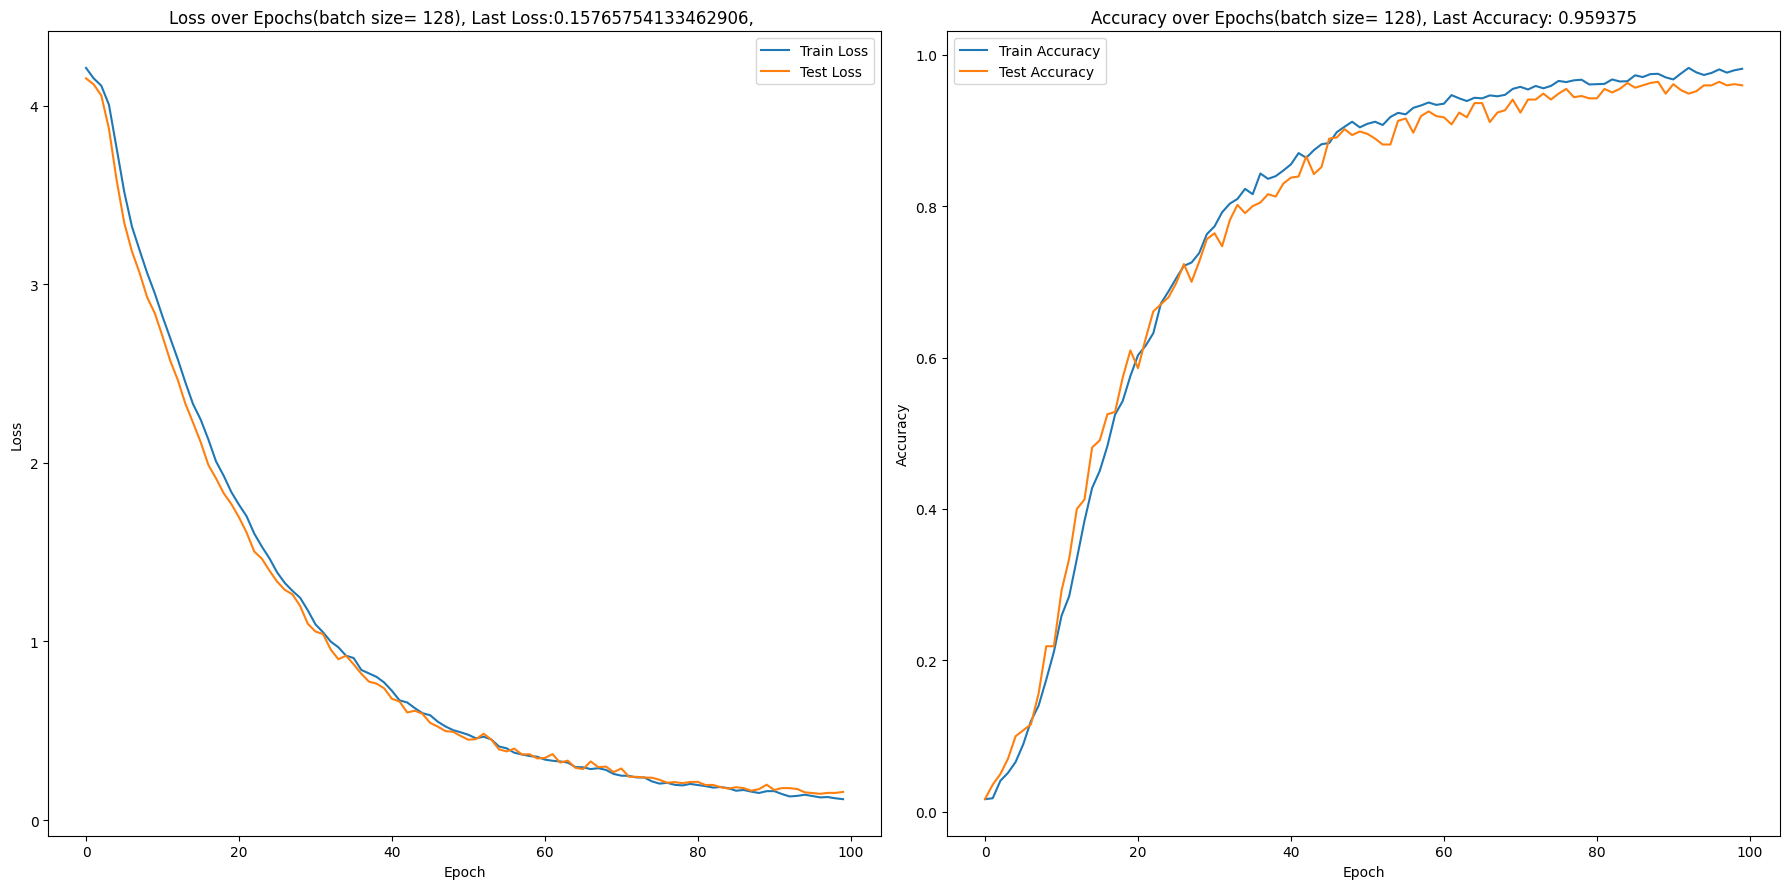

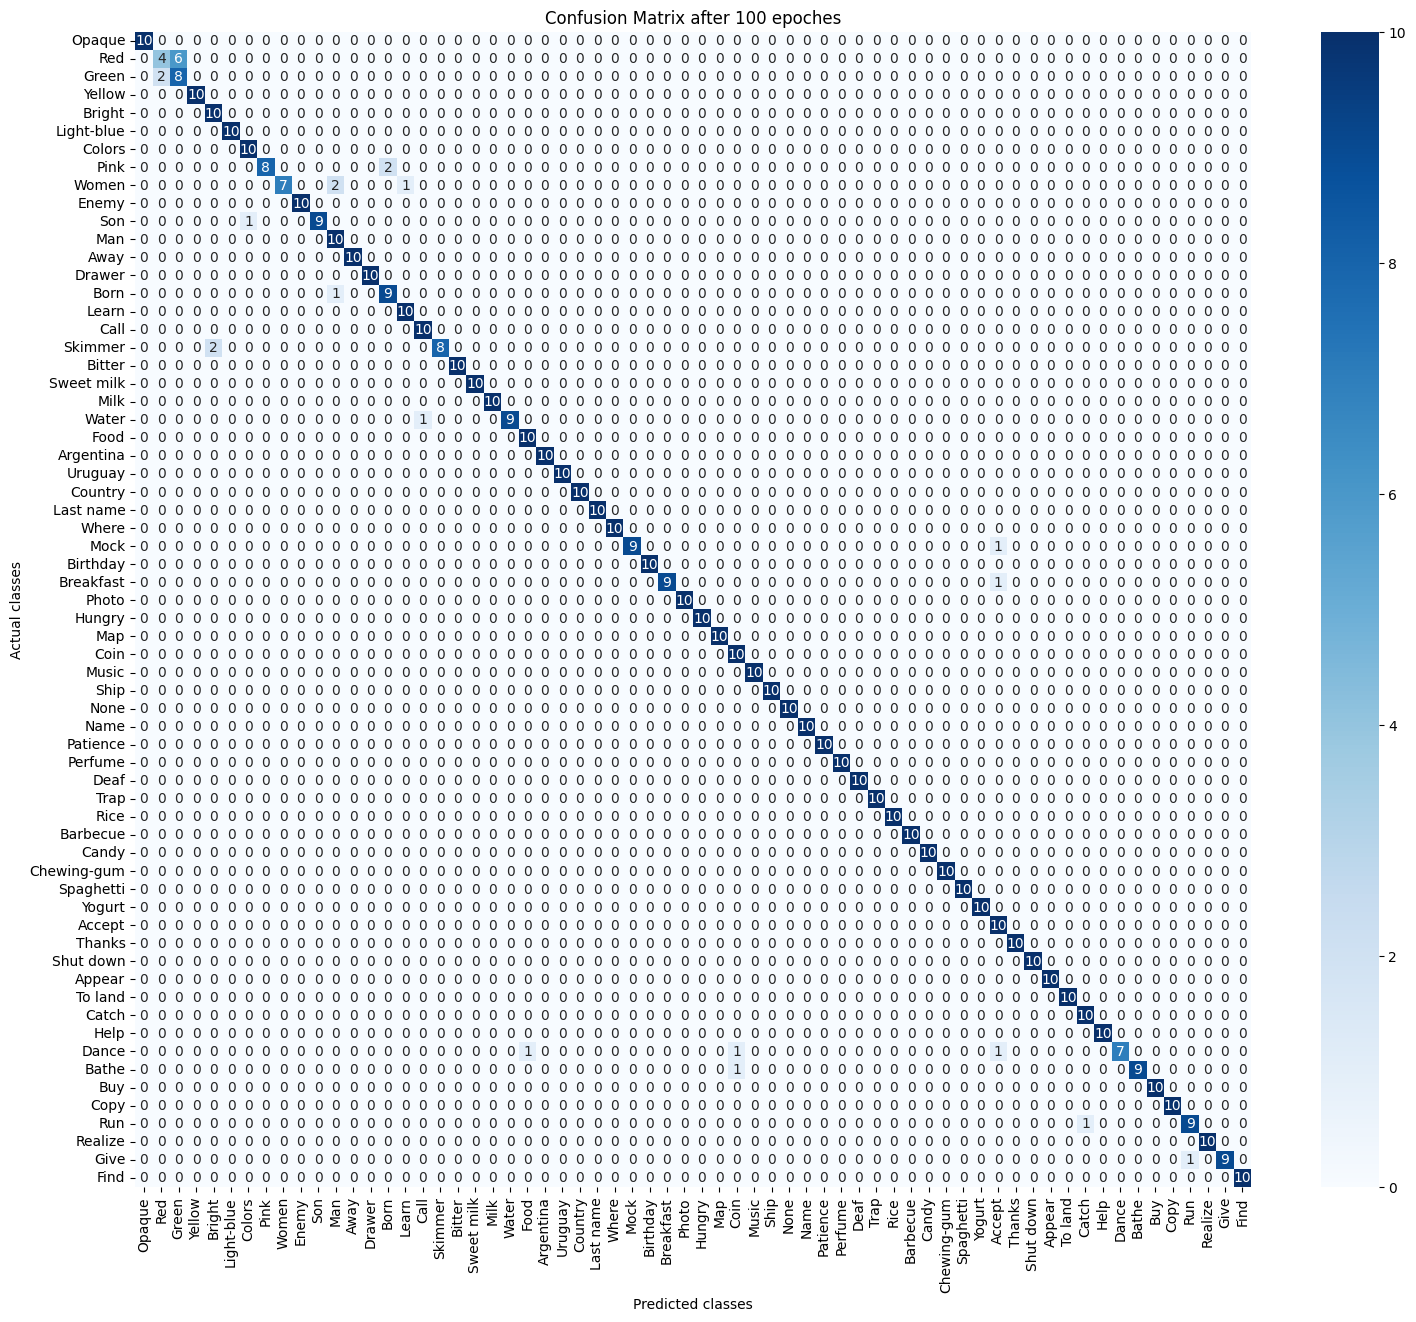

In [8]:
model= models.LinearParamTransformer(prepare_datasets.lsa64class_names, 40, 128, 4, 2048, 2, 1662)
set_train_parameters(lsa64['40fps'], lsa64_labels['40fps'], prepare_datasets.lsa64class_names, 0.2, 42, 128, 100, model, 0.0001, device)

Training Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

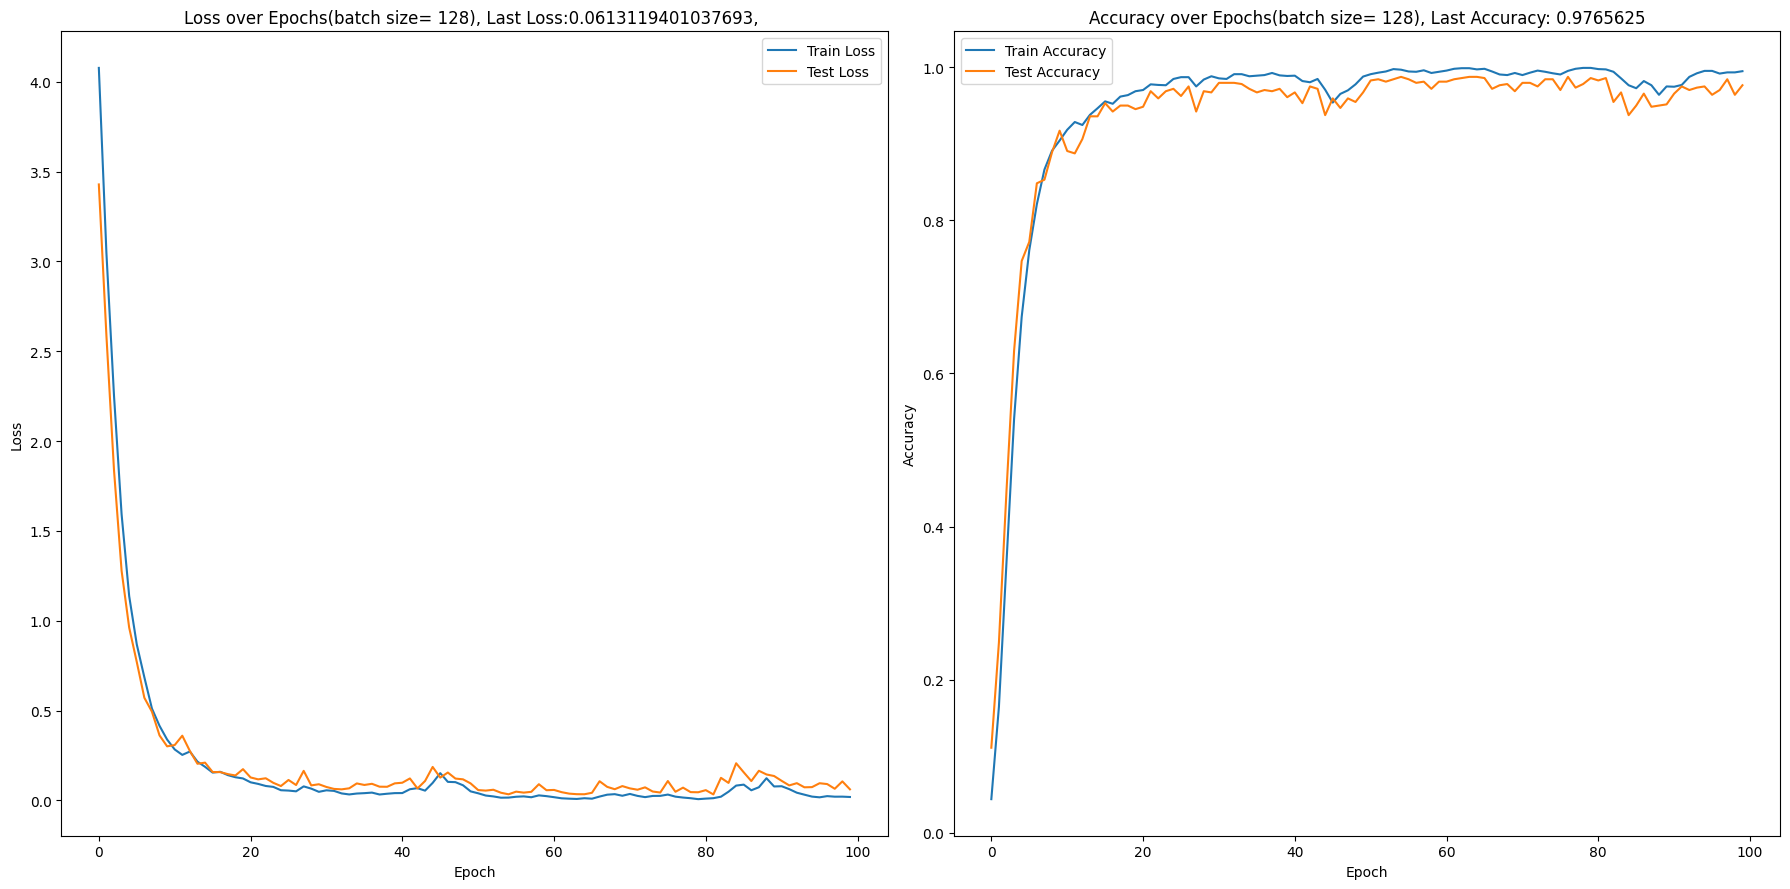

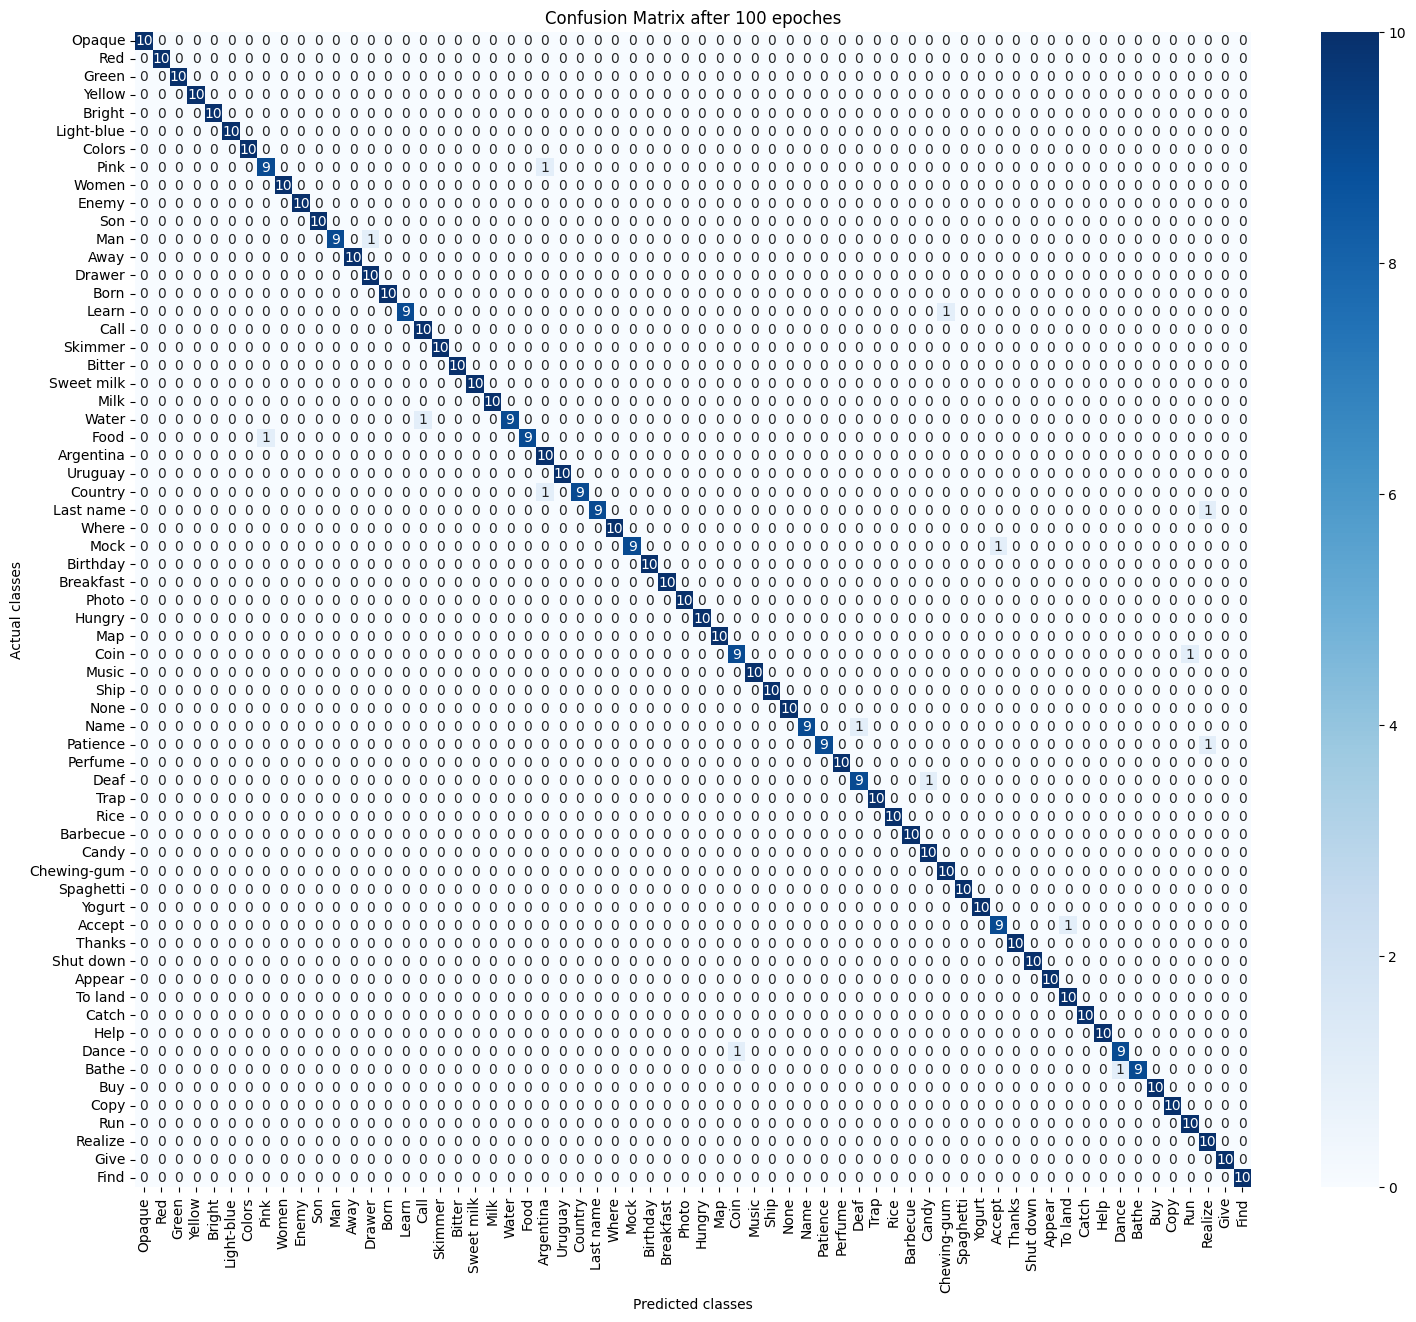

In [10]:
model= models.Transformer(prepare_datasets.lsa64class_names)
set_train_parameters(lsa64['40fps'], lsa64_labels['40fps'], prepare_datasets.lsa64class_names, 0.2, 42, 128, 100, model, 0.0001, device)